# Introduction

**Adversarial attack** is a technique used to manipulate machine learning models by intentionally inputting maliciously crafted data in order to deceive the model's output. The goal of an adversarial attack is to cause the model to make incorrect predictions or classifications. Hence, an adversarial example is an input to a machine learning model that is purposely designed to cause a model to make a mistake in its predictions despite resembling a valid input to a human.


Black-box and white-box attacks are two distinct approaches to adversarial attacks in the context of machine learning models.


In a **black-box attack**, the attackers have limited or no knowledge about the internal workings of the target model.
The attackers can only access the input-output behavior of the model, meaning they can provide inputs to the model and observe the corresponding outputs.
Common strategies for black-box attacks include transferability attacks, where adversarial examples generated for one model are effective against another model trained on similar data, and query-based attacks, where the attackers interact with the model to generate adversarial examples through queries.



In a **white-box attack**, the attackers have complete knowledge of the target model, including its architecture, parameters, and possibly even its training data.
The attackers can directly access and manipulate the internal components of the model, such as gradients, activations, and weights.
White-box attacks often result in more potent adversarial examples compared to black-box attacks because the attackers can exploit detailed knowledge about the model's vulnerabilities.
Common white-box attack strategies include gradient-based attacks, where gradients of the model's loss function with respect to the input are used to generate adversarial perturbations, and optimization-based attacks, where adversarial examples are generated by solving optimization problems with constraints imposed by the model's architecture and output.

In this project fast gradient sign attack will be performed.

The fast gradient sign method is a technique that leverages the gradients of a neural network to generate adversarial examples. Essentially, it exploits the sensitivity of the model's predictions to small changes in the input data. Here's how it works:

*   Gradients Calculation: The method computes the gradients of the loss function with respect to the input image. These gradients indicate how the loss would change if the input image were adjusted slightly.

*   Maximizing Loss: By using the sign of these gradients, the method generates a new image that maximizes the loss function. It does this by adjusting the pixels of the input image in the direction that increases the loss the most.

*   Adversarial Image: The resulting image, called the adversarial image, appears similar to the original input image but is crafted to deceive the neural network into making a wrong prediction or classification.


In summary, the fast gradient sign method exploits the neural network's sensitivity to input perturbations by using gradients to create adversarial images that fool the model into making incorrect predictions.

# Imports

In [1]:
import cv2
import os
import random
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import seaborn as sns

from google.colab import drive

from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import load_model, Model
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Constants

In [2]:
main_directory = '/content/gdrive/MyDrive/adversarial_attack'
dataset_dir_name = 'images'
log_directory_name = 'logs'
checkpoint_directory_name = 'checkpoints'
model_directory_name = 'model'
train_dir = 'train'
test_dir = 'test'
model_file_name = 'resnet.h5'

image_size = (224, 224)
input_shape = (224, 224, 3)
batch_size = 4

# Mounting with Google Drive

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Preparing the dataset

## Reading and preparing images


In [4]:
def load_img(indir):
    samples = []
    labels = []
    num_classes = 0
    for class_dir in os.listdir(indir):
        if not os.path.isdir(os.path.join(indir, class_dir)):
          continue
        print('Loading: ', class_dir)
        the_class = class_dir
        num_classes += 1
        for img_file in os.listdir(os.path.join(indir, class_dir)):
            image = cv2.imread('{}/{}/{}'.format(indir, class_dir, img_file))
            image = cv2.resize(image, image_size)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = tf.keras.applications.resnet.preprocess_input(image)
            samples.append(image)
            labels.append(the_class)
    samples = np.array(samples)
    labels = np.array(labels)
    return samples, labels, num_classes

In [5]:
train_samples, train_labels, num_classes = load_img(os.path.join(main_directory, os.path.join(dataset_dir_name, train_dir)))
test_samples, test_labels, _ = load_img(os.path.join(main_directory, os.path.join(dataset_dir_name, test_dir)))

Loading:  Turtle
Loading:  Penguin
Loading:  Penguin
Loading:  Turtle


## Checking if train and test sets are balanced

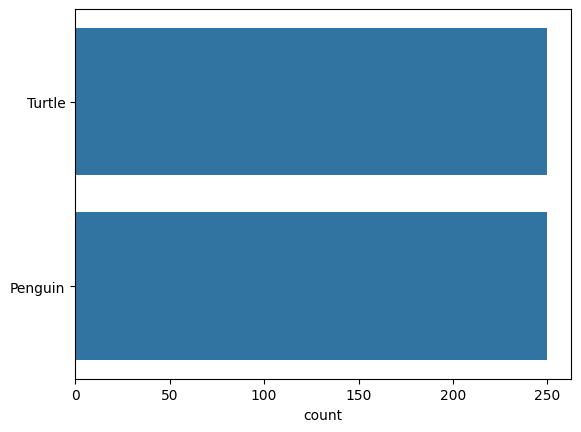

In [ ]:
sns.countplot(data = train_labels)
plt.show()

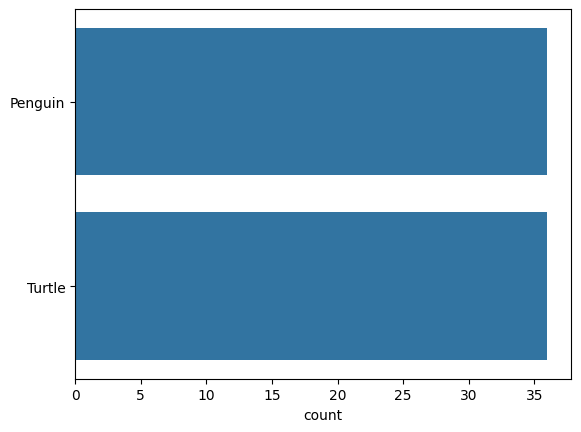

In [ ]:
sns.countplot(data = test_labels)
plt.show()

## Creating validation set (in the dataset were only test and training set)

In [6]:
train_samples, val_samples, train_labels, val_labels = train_test_split(train_samples, train_labels, test_size = 0.2, random_state = 42, shuffle=True)

## Shuffling the test set (train and validation sets were shuffled during split)

In [7]:
indices = np.arange(test_labels.shape[0])
np.random.shuffle(indices)

test_samples = test_samples[indices]
test_labels = test_labels[indices]

## Checking if samples size is same with labels size

In [ ]:
print('Train samples length: {}'.format(len(train_samples)))
print('Train labels length: {}'.format(len(train_labels)))
print('Validation samples length: {}'.format(len(val_samples)))
print('Validation labels length: {}'.format(len(val_labels)))
print('Test samples length: {}'.format(len(test_samples)))
print('Test labels length: {}'.format(len(test_labels)))

Train samples length: 400
Train labels length: 400
Validation samples length: 100
Validation labels length: 100
Test samples length: 72
Test labels length: 72


## Labels encoding

In [8]:
lb = LabelBinarizer()

train_labels_encoded = lb.fit_transform(train_labels)
print("Train labels shape: ", train_labels_encoded.shape)

val_labels_encoded = lb.transform(val_labels)
print("Val labels shape: ", val_labels_encoded.shape)

test_labels_encoded = lb.transform(test_labels)
print("Test labels shape: ", test_labels_encoded.shape)

Train labels shape:  (400, 1)
Val labels shape:  (100, 1)
Test labels shape:  (72, 1)


# Training

To perform adversarial attack, there must be pretrained model. I decided to train ResNet50 model that will distinguish penguins from turtles.

## Loading ResNet50 model and adding top layers specified for this task

In [ ]:
base_resnet = ResNet50(include_top = False, weights = 'imagenet')
avg = GlobalAveragePooling2D()(base_resnet.output)
out = Dense(1, activation = 'sigmoid')(avg)
resnet = Model(inputs=base_resnet.input, outputs=out)

## Freezing layers in base model

Model is pretrained on ImageNet dataset so there is no need to train whole model. If the model's performance after training is unsatisfactory, there is possibility to gradually unfreeze subsequent layers, but in this case it will not be necessary.

In [ ]:
for layer in base_resnet.layers:
  layer.trainable = False

## Summary, compilation and training

In [ ]:
resnet.summary()
resnet.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
model_image_path = os.path.join(main_directory, os.path.join(model_directory_name, 'resnet.png'))
tf.keras.utils.plot_model(resnet, to_file=model_image_path, show_shapes=True, show_layer_names=True, show_dtype=True, dpi=80)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
tensorboard = TensorBoard(log_dir=os.path.join(main_directory, log_directory_name))
checkpoint = ModelCheckpoint(filepath=os.path.join(main_directory, checkpoint_directory_name),
                             monitor='val_accuracy',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1
                            )
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

In [ ]:
resnet_history = resnet.fit(train_samples, train_labels_encoded,
                                      batch_size = batch_size,
                                      epochs = 10,
                                      validation_data = (val_samples, val_labels_encoded),
                                      callbacks=[tensorboard, checkpoint, early_stopping])

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.2300 - accuracy: 0.9050
Epoch 1: val_accuracy improved from -inf to 0.99000, saving model to /content/gdrive/MyDrive/adversarial_attack/checkpoints
100/100 [==============================] - 115s 1s/step - loss: 0.2300 - accuracy: 0.9050 - val_loss: 0.0559 - val_accuracy: 0.9900
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.0393 - accuracy: 0.9950
Epoch 2: val_accuracy improved from 0.99000 to 1.00000, saving model to /content/gdrive/MyDrive/adversarial_attack/checkpoints
100/100 [==============================] - 109s 1s/step - loss: 0.0393 - accuracy: 0.9950 - val_loss: 0.0361 - val_accuracy: 1.0000
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.0243 - accuracy: 0.9975
Epoch 3: val_accuracy did not improve from 1.00000
100/100 [==============================] - 85s 854ms/step - loss: 0.0243 - accuracy: 0.9975 - val_loss: 0.0286 - val_accuracy: 1.0000
Epoch 4/10
1

In [ ]:
resnet_hist_ = pd.DataFrame(resnet_history.history)
resnet_hist_

,loss,accuracy,val_loss,val_accuracy
0,0.229996,0.9050,0.055923,0.99
1,0.039339,0.9950,0.036050,1.00
2,0.024252,0.9975,0.028597,1.00
3,0.016561,0.9975,0.018517,1.00
4,0.011508,0.9975,0.019451,1.00
5,0.008488,1.0000,0.013651,1.00
6,0.006747,1.0000,0.012702,1.00
7,0.005494,1.0000,0.010653,1.00
8,0.004570,1.0000,0.010043,1.00
9,0.003734,1.0000,0.009896,1.00


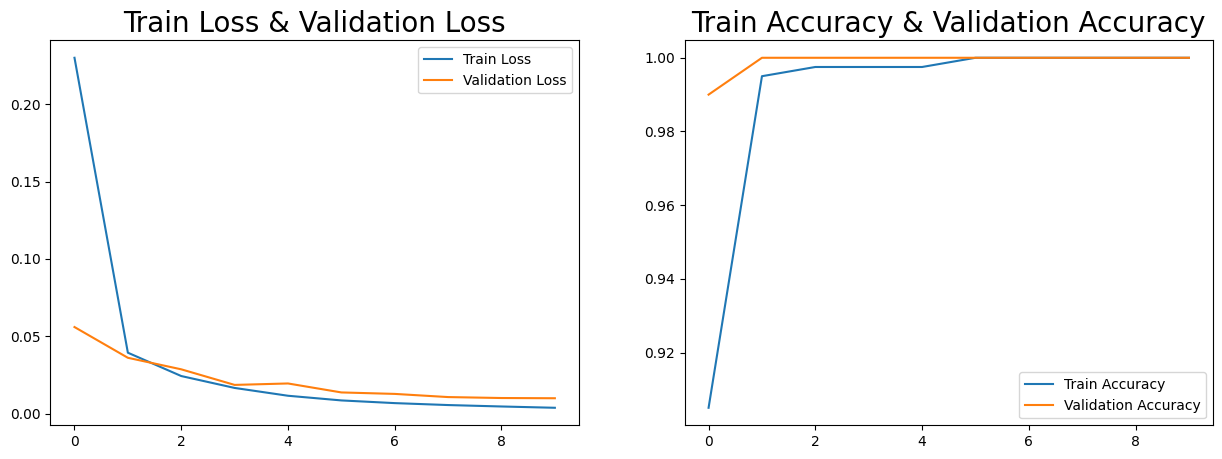

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(resnet_hist_['loss'], label='Train Loss')
plt.plot(resnet_hist_['val_loss'], label='Validation Loss')
plt.title('Train Loss & Validation Loss', fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(resnet_hist_['accuracy'], label='Train Accuracy')
plt.plot(resnet_hist_['val_accuracy'], label='Validation Accuracy')
plt.title('Train Accuracy & Validation Accuracy', fontsize=20)
plt.legend()

# Evaluating the model

In [10]:
predictions = resnet.predict(test_samples)
threshold = 0.5 # if prediction is smaller than threshold, in the image is penguin else in the image is turtle
binary_predictions = (predictions >= threshold).astype(int)

3/3 [==============================] - 13s 3s/step


## Confusion matrix

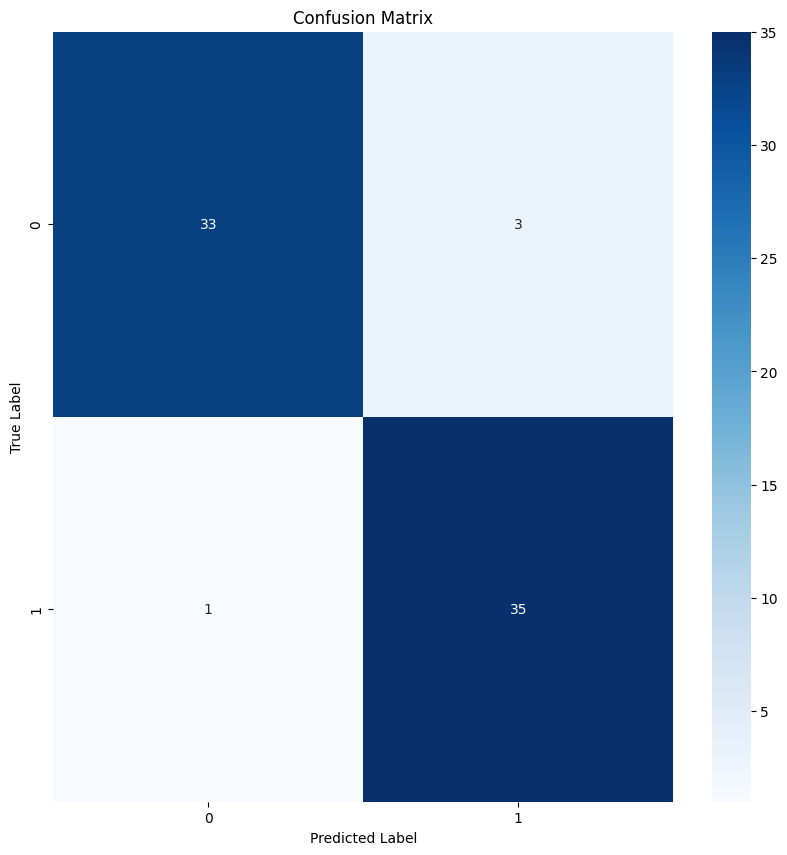

In [11]:
conf_matrix = confusion_matrix(test_labels_encoded, binary_predictions)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## Classification report

In [12]:
cls_report = classification_report(test_labels_encoded, binary_predictions)
print(cls_report)

              precision    recall  f1-score   support

           0       0.97      0.92      0.94        36
           1       0.92      0.97      0.95        36

    accuracy                           0.94        72
   macro avg       0.95      0.94      0.94        72
weighted avg       0.95      0.94      0.94        72



## Plotting images with their real labels and predicted labels

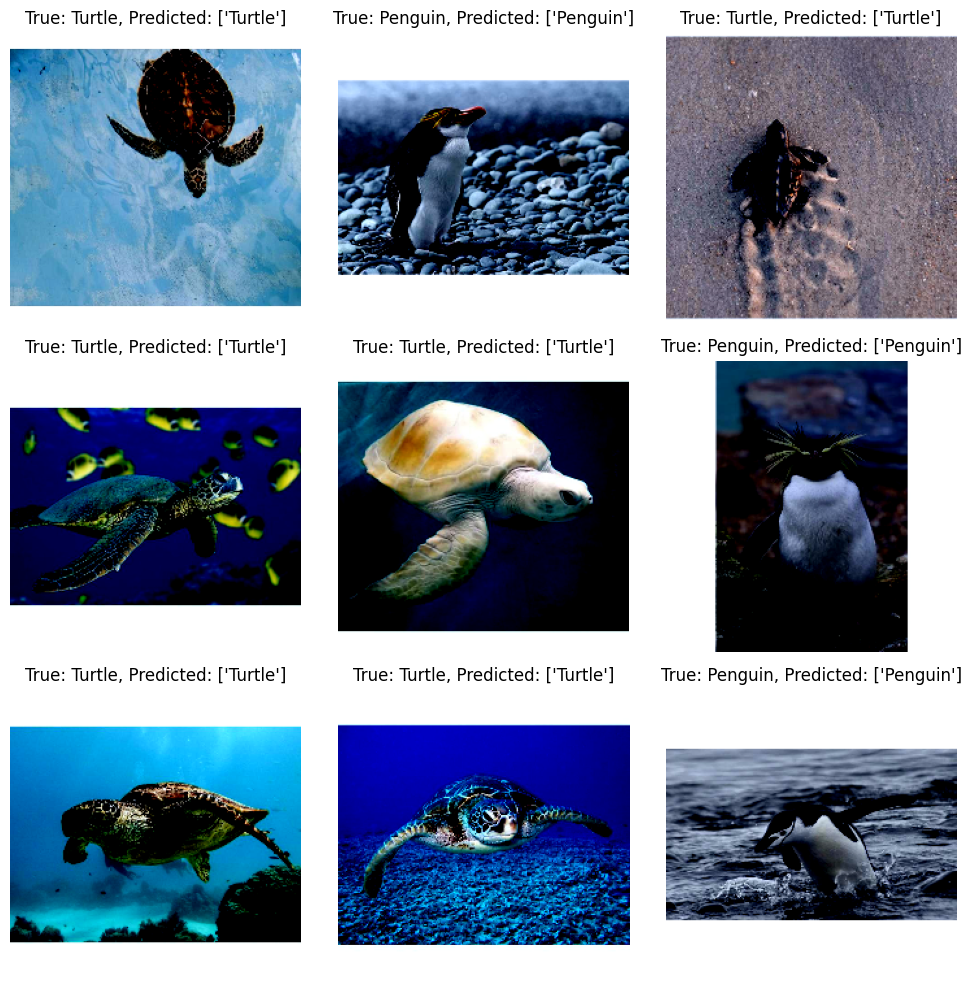

In [ ]:
num_samples = len(test_samples)
random_indices = np.random.choice(num_samples, 9, replace=False)

fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, idx in enumerate(random_indices):
    ax = axes[i // 3, i % 3]
    ax.imshow((cv2.cvtColor(test_samples[idx], cv2.COLOR_BGR2RGB) - 1 )/ 127.5)
    ax.set_title(f'True: {test_labels[idx]}, Predicted: {lb.inverse_transform(binary_predictions[idx])}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Saving the model

In [ ]:
resnet.save(os.path.join(main_directory, os.path.join(model_directory_name, model_file_name)))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Loading the model

In [9]:
resnet = load_model(os.path.join(main_directory, os.path.join(model_directory_name, model_file_name)))

# Adversarial attack

Model has been trained and has sufficient performance. Now it is time to perform fast gradient sign attack.

In [24]:
penguin_index = 15 # index of image in which we can see penguin
image = test_samples[penguin_index].reshape(1, 224, 224, 3) # reshape needed to match the input shape of the model
input_image = tf.Variable(image)
loss_object = tf.keras.losses.CategoricalCrossentropy()

In [14]:
def display_images(image, description):
  prediction = resnet.predict(image)
  label = lb.inverse_transform((prediction >= threshold).astype(int))
  confidence = 1 - prediction[0][0] if prediction[0][0] < threshold else prediction[0][0] # this line might need some explanation
                                                                                          # this model performs binary regression
                                                                                          # it treates 'Penguin' class as negative class and 'Turtle' as positive one
                                                                                          # it means that when if the model prediction is smaller than 0.5,
                                                                                          # the predicted class is penguin
                                                                                          # to have proper confidence, if predicted class is penguin
                                                                                          # (so if the prediction is smaller than 0.5)
                                                                                          # the confidence is equal to 1 - prediction
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description, label, confidence*100))
  plt.show()

Before performing the attack, let's see prediction and confidence of this prediction of original model:

1/1 [==============================] - 0s 246ms/step


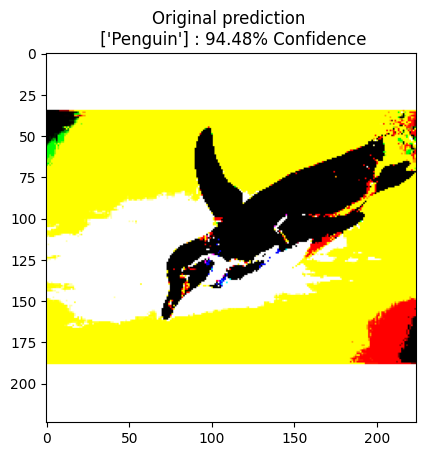

In [25]:
display_images(input_image, 'Original prediction')

First step to perform attack is to create perturbations which will be used to distort the original image resulting in an adversarial image.

In [26]:
def create_adversarial_pattern(input_images, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = resnet(input_image)
    loss = (input_label, prediction)
  gradient = tape.gradient(loss, input_image)
  signed_grad = tf.sign(gradient)
  return signed_grad

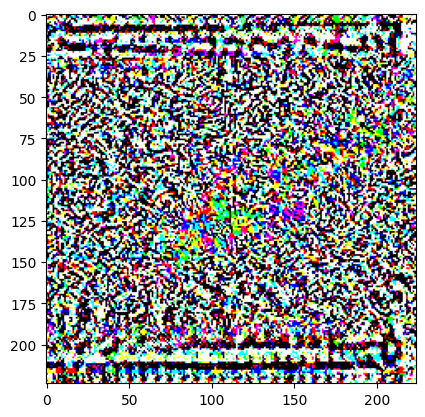

In [32]:
label = tf.one_hot(penguin_index, predictions[penguin_index].shape[-1])
label = tf.reshape(label, (1, predictions[penguin_index].shape[-1]))

perturbations = create_adversarial_pattern(input_image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]

Resulting perturbation is presented above.

In the second step experiments with different values of epsilon were performed. For every value of epsilon, image with penguin has been classified as image with turtle. Adversarial attack has been performed successfully.

1/1 [==============================] - 0s 284ms/step


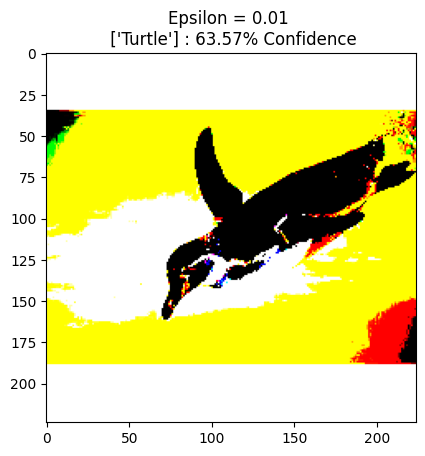

1/1 [==============================] - 0s 329ms/step


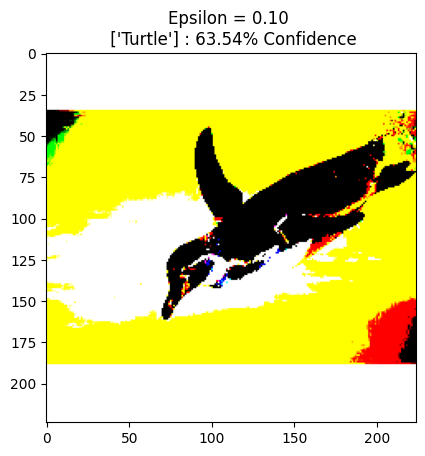

1/1 [==============================] - 0s 284ms/step


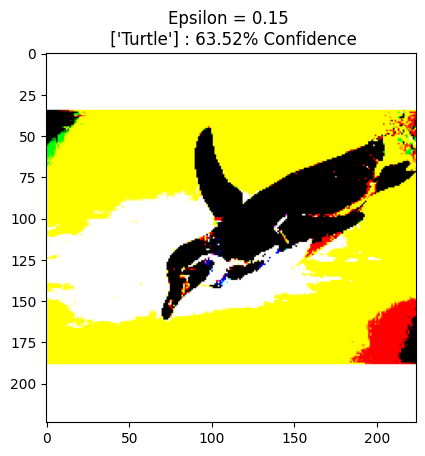

1/1 [==============================] - 0s 312ms/step


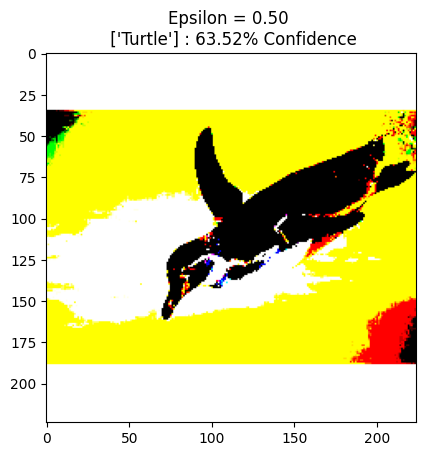

1/1 [==============================] - 0s 182ms/step


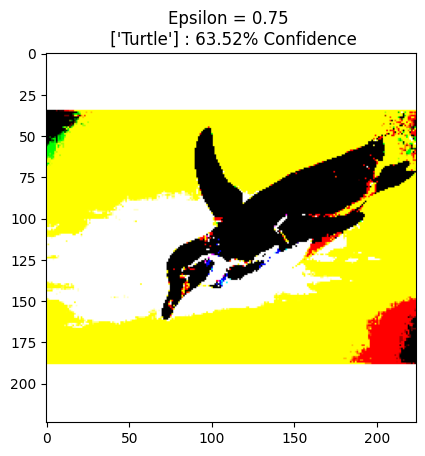

1/1 [==============================] - 0s 188ms/step


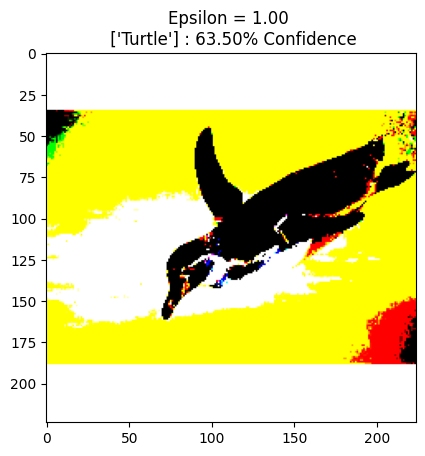

In [34]:
epsilons = [0.01, 0.1, 0.15, 0.5, 0.75, 1.0]
descriptions = [('Epsilon = {:0.2f}'.format(eps)) for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])

# Conclusions

Adversarial attacks pose a significant challenge to the deployment of machine learning models, particularly in security-critical applications such as autonomous vehicles, cybersecurity, and biometric authentication systems. Researchers are actively developing defense mechanisms to mitigate the impact of adversarial attacks, but it remains an ongoing area of research and concern in the field of machine learning and artificial intelligence.

# Sources

While working on this project, following sources were used:

*   https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial10/Adversarial_Attacks.html
*   https://www.tensorflow.org/tutorials/generative/adversarial_fgsm
*   https://viso.ai/deep-learning/adversarial-machine-learning/



Dataset:
https://www.kaggle.com/datasets/gauravduttakiit/penguins-vs-turtles
